# Integrantes do grupo
Bernardo Dutra Lemos - 2022043949 <br>
Beatriz Reis Gama Barbosa - 2022043922 <br>
Giovanna Naves Ribeiro - 2022043647 <br>
João Lucas Simões Moreira - 2022043485 <br>
# Tema -> Músicas
# Favor executar no colab!

# Imports e definições auxiliares

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import math
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# Retorna o intervalo de confiança com 95%.
def Intervalo_de_confianca(diffs):
  return (np.percentile(diffs,0.5), np.percentile(diffs,99.5))

# Faz o teste de permutação de uma determinada base, devolve as diferenças e
# o valor observado conforme o filtro especificado.
def shuffling(data, col, filtro, N, mean=True, log=False):
  if log:
    data[col] = [math.log(x,10) for x in data[col].values]

  if (mean):
    t_obs = data[filtro][col].mean() - data[~filtro][col].mean()
  else:
    t_obs = data[filtro][col].median() - data[~filtro][col].median()

  diffs = np.zeros(N)
  for i in range(N):
    np.random.seed(i)
    np.random.shuffle(filtro.values)
    if(mean):
      diffs[i] = data[filtro][col].mean() - data[~filtro][col].mean()
    else:
      diffs[i] = data[filtro][col].median() - data[~filtro][col].median()
  return diffs,t_obs

# Retorna o p-valor.
def p_value(t_obs, diffs):
  return (diffs > t_obs).mean()

# Avalia se a hipótese nula será rejeitada ou não com base no seu valor observado
# Usado na pergunta 3
def compare(feature, choicelist):
  for szn in choicelist:
      filtro = timeframe['season'] == szn
      diffs, t_obs = shuffling(timeframe, feature, filtro, 100)
      intervalo = Intervalo_de_confianca(diffs)

      print("\nEstação: " + szn)
      print('Intervalo de confiança com 99%: ', intervalo, '| Valor observado: ', t_obs)
      print("P-valor: ", p_value(t_obs, diffs))

      if t_obs < intervalo[0] or t_obs > intervalo[1]:
          print('Rejeita H0, ou seja, a diferença de mediana de ' + feature + ' é significativa para a estação ' + szn + '\n')
      else:
          print('Não rejeita H0, ou seja, a diferença de mediana de ' + feature + ' não é significativa para a estação ' + szn + '\n')


## Descrição dos detalhes técnicos das músicas <br>
**Acousticness:** numérico, varia de 0 a 1 e mede se uma música é acústica ou não. <br>
**Danceability:** numérico, varia de 0 a 1 e descreve o quanto uma música é boa para dançar baseado em uma combinação de elementos como tempo, força da batida, etc. <br>
**Duration_ms:** numérico, tempo de duração da música em milissegundos. <br>
**Energy:** numérico, varia de 0 a 1 e representa uma avaliação da intensidade da música. Músicas energéticas são barulhentas, por exemplo. <br>
**Instrumentalness:** numérico, varia de 0 a 1 e representa se uma música possui ou não vocais. <br>
**Key:** numérico, estima a tonalidade da música. Se for -1, não foi possível detectá-la. <br>
**Liveness:** numérico, varia de 0 a 1, detecta a presença de plateia na música. <br>
**Loudness:** numérico, varia de -60 a 0, estima o valor da música em decibéis. <br>
**Mode:** numérico, varia de 0 a 1, estima a modalidade da música, ou seja, a escala de onde o conteúdo da música é derivado. <br>
**Speechiness:** numérico, varia de 0 a 1, detecta a presença de palavras ditas na música. *OBS:* a diferença entre speechiness e instrumentalness é que o speechiness considera palavras ditas, enquanto que o instrumentalness pode considerar barulhos (como 'ooh', 'aah', etc.) <br>
**Tempo:** numérico, representa o BPM da música. <br>
**Valence:** numérico, varia de 0 a 1, descreve a positividade da música.

## Import e visualização das bases

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df_albums = pd.read_csv('/content/drive/MyDrive/TP_ICD_20232/albums.csv')
df_features = pd.read_csv('/content/drive/MyDrive/TP_ICD_20232/features.csv')
df_spotify_youtube = pd.read_csv('/content/drive/MyDrive/TP_ICD_20232/Spotify_Youtube.csv')
df_spotify_2022 = pd.read_csv('/content/drive/MyDrive/TP_ICD_20232/spotify_top_charts_22.csv')

Mounted at /content/drive


In [ ]:
df_albums.head()

,id,date,artist,album,rank,length,track_length
0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-01-19,A Boogie Wit da Hoodie,Hoodie SZN,1.0,20.0,185233.800000
2,3,2019-01-19,21 Savage,I Am > I Was,2.0,15.0,211050.733333
3,4,2019-01-19,Soundtrack,Spider-Man: Into The Spider-Verse,3.0,13.0,190866.384615
4,5,2019-01-19,Meek Mill,Championships,4.0,19.0,219173.894737


In [ ]:
df_features.head()

,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date
0,0Veyvc3n9AcLSoK3r1dA12,Voices In My Head,Hoodie SZN,A Boogie Wit da Hoodie,0.0555,0.754,142301.0,0.663,0.000000,6.0,0.101,-6.311,0.0,0.427,90.195,4.0,0.207,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
1,77JzXZonNumWsuXKy9vr3U,Beasty,Hoodie SZN,A Boogie Wit da Hoodie,0.2920,0.860,152829.0,0.418,0.000000,7.0,0.106,-9.061,0.0,0.158,126.023,4.0,0.374,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
2,18yllZD0TdF7ykcREib8Z1,I Did It,Hoodie SZN,A Boogie Wit da Hoodie,0.1530,0.718,215305.0,0.454,0.000046,8.0,0.116,-9.012,1.0,0.127,89.483,4.0,0.196,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
3,1wJRveJZLSb1rjhnUHQiv6,Swervin (feat. 6ix9ine),Hoodie SZN,A Boogie Wit da Hoodie,0.0153,0.581,189487.0,0.662,0.000000,9.0,0.111,-5.239,1.0,0.303,93.023,4.0,0.434,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
4,0jAfdqv18goRTUxm3ilRjb,Startender (feat. Offset and Tyga),Hoodie SZN,A Boogie Wit da Hoodie,0.0235,0.736,192779.0,0.622,0.000000,6.0,0.151,-4.653,0.0,0.133,191.971,4.0,0.506,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21


In [ ]:
df_spotify_youtube.head()

,Unnamed: 0,Artist,Url_spotify,Track,Album,Album_type,Uri,Danceability,Energy,Key,...,Url_youtube,Title,Channel,Views,Likes,Comments,Description,Licensed,official_video,Stream
0,0,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,Feel Good Inc.,Demon Days,album,spotify:track:0d28khcov6AiegSCpG5TuT,0.818,0.705,6.0,...,https://www.youtube.com/watch?v=HyHNuVaZJ-k,Gorillaz - Feel Good Inc. (Official Video),Gorillaz,693555221.0,6220896.0,169907.0,Official HD Video for Gorillaz' fantastic trac...,True,True,1.040235e+09
1,1,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,Rhinestone Eyes,Plastic Beach,album,spotify:track:1foMv2HQwfQ2vntFf9HFeG,0.676,0.703,8.0,...,https://www.youtube.com/watch?v=yYDmaexVHic,Gorillaz - Rhinestone Eyes [Storyboard Film] (...,Gorillaz,72011645.0,1079128.0,31003.0,The official video for Gorillaz - Rhinestone E...,True,True,3.100837e+08
2,2,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,New Gold (feat. Tame Impala and Bootie Brown),New Gold (feat. Tame Impala and Bootie Brown),single,spotify:track:64dLd6rVqDLtkXFYrEUHIU,0.695,0.923,1.0,...,https://www.youtube.com/watch?v=qJa-VFwPpYA,Gorillaz - New Gold ft. Tame Impala & Bootie B...,Gorillaz,8435055.0,282142.0,7399.0,Gorillaz - New Gold ft. Tame Impala & Bootie B...,True,True,6.306347e+07
3,3,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,On Melancholy Hill,Plastic Beach,album,spotify:track:0q6LuUqGLUiCPP1cbdwFs3,0.689,0.739,2.0,...,https://www.youtube.com/watch?v=04mfKJWDSzI,Gorillaz - On Melancholy Hill (Official Video),Gorillaz,211754952.0,1788577.0,55229.0,Follow Gorillaz online:\nhttp://gorillaz.com \...,True,True,4.346636e+08
4,4,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,Clint Eastwood,Gorillaz,album,spotify:track:7yMiX7n9SBvadzox8T5jzT,0.663,0.694,10.0,...,https://www.youtube.com/watch?v=1V_xRb0x9aw,Gorillaz - Clint Eastwood (Official Video),Gorillaz,618480958.0,6197318.0,155930.0,The official music video for Gorillaz - Clint ...,True,True,6.172597e+08


In [ ]:
df_spotify_2022.head()

,uri,artist_names,track_name,peak_rank,weeks_on_chart,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,duration_ms
0,spotify:track:02MWAaffLxlfxAUY7c5dvx,Glass Animals,Heat Waves,1,65,0.761,0.525,11,-6.900,1,0.0944,0.4400,0.000007,0.0921,80.870,4,238805
1,spotify:track:5PjdY0CKGZdEuoNab3yDmX,"The Kid LAROI, Justin Bieber",STAY (with Justin Bieber),1,37,0.591,0.764,1,-5.484,1,0.0483,0.0383,0.000000,0.1030,169.928,4,141806
2,spotify:track:3IAfUEeaXRX9s9UdKOJrFI,Anitta,Envolver,3,3,0.812,0.736,4,-5.421,0,0.0833,0.1520,0.002540,0.0914,91.993,4,193806
3,spotify:track:1HhNoOuqm1a5MXYEgAFl8o,"Imagine Dragons, JID, Arcane, League of Legends",Enemy (with JID) - from the series Arcane Leag...,3,21,0.728,0.783,11,-4.424,0,0.2660,0.2370,0.000000,0.4340,77.011,4,173381
4,spotify:track:4fouWK6XVHhzl78KzQ1UjL,GAYLE,abcdefu,1,19,0.695,0.540,4,-5.692,1,0.0493,0.2990,0.000000,0.3670,121.932,4,168602


#Pergunta 1: Como foi a evolução da popularidade internacional de artistas latinos do século XXI?


Começaremos mapeando a presença de artistas latinos na base da Billboard. Como não existe um filtro de nacionalidade, pesquisou-se manualmente quais os artistas latinos presentes no top 200 da Billboard com uma frequência minimamente significativa, e eles foram inseridos em um array. Após isso, foi plotado um gráfico de linhas para fazer uma visualização inicial da presença desses artistas na base.

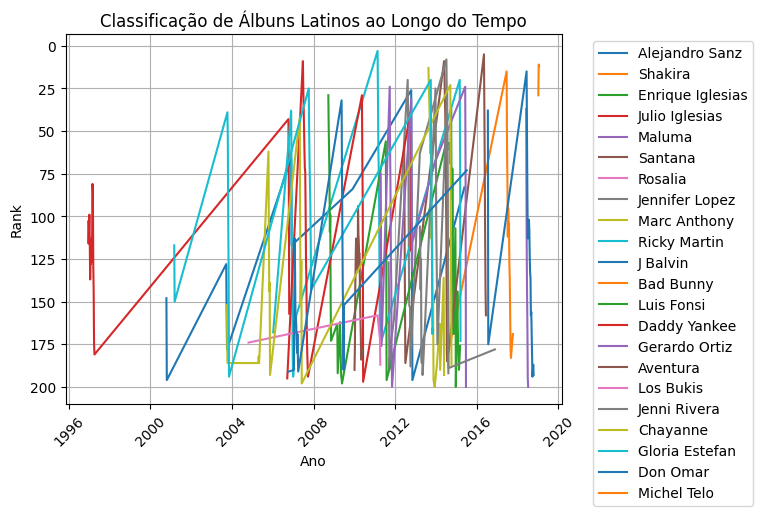

In [ ]:
df_albums = (df_albums).dropna()
artistas = ['Alejandro Sanz', 'Shakira', 'Enrique Iglesias', 'Julio Iglesias', 'Maluma', 'Santana', 'Rosalia', 'Jennifer Lopez', 'Marc Anthony', 'Ricky Martin', 'J Balvin', 'Bad Bunny', 'Luis Fonsi', 'Daddy Yankee', 'Gerardo Ortiz', 'Aventura', 'Los Bukis', 'Jenni Rivera', 'Chayanne', 'Gloria Estefan', 'Don Omar', 'Michel Telo']
top_albums_df = pd.DataFrame(columns=['date', 'artist', 'album', 'rank'])

for artist_name in artistas:
    artist_df = df_albums[df_albums['artist'] == artist_name].dropna()
    top_albums_df = top_albums_df.append(artist_df[['date', 'artist', 'album', 'rank']].drop_duplicates().head(20), ignore_index=True)

top_albums_df

top_albums_df['date'] = pd.to_datetime(top_albums_df['date'])

for artist_name in artistas:
    artist_data = top_albums_df[top_albums_df['artist'] == artist_name]
    plt.plot(artist_data['date'], artist_data['rank'], label=artist_name)

plt.title('Classificação de Álbuns Latinos ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Rank')
plt.grid(True)
plt.legend(bbox_to_anchor=[1.05, 1], loc='upper left')

plt.xticks(rotation=45)
plt.gca().invert_yaxis()

plt.show()

Após isso, agrupamos os artistas latinos por ano e somamos sua popularidade (é importante ressaltar que a popularidade é inversamente proporcional ao número do rank). Com isso, começamos a supor um crescimento na popularidade desses artistas ao longo dos anos.

<Figure size 1400x500 with 0 Axes>

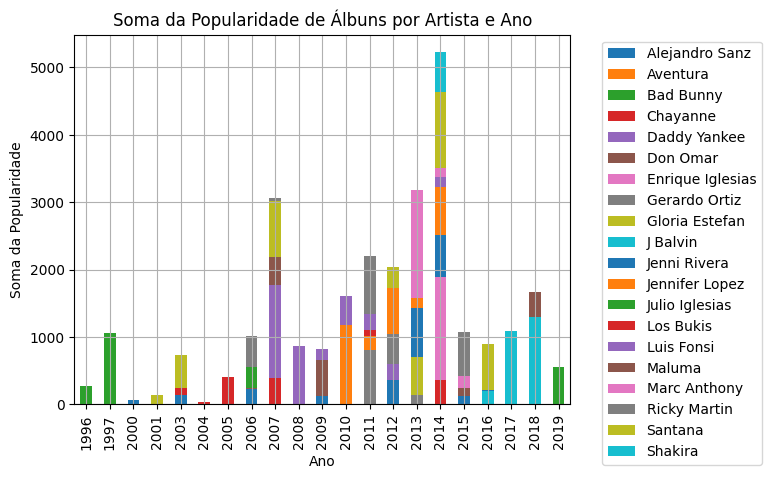

In [ ]:
top_albums_df['popularidade'] = 201 - top_albums_df['rank']

yearly_popularity_sum = top_albums_df.groupby([top_albums_df['date'].dt.year, 'artist'])['popularidade'].sum().unstack().fillna(0)

plt.figure(figsize=(14, 5))
ax = yearly_popularity_sum.plot(kind='bar', stacked=True)
plt.title('Soma da Popularidade de Álbuns por Artista e Ano')
plt.xlabel('Ano')
plt.ylabel('Soma da Popularidade')
plt.grid(True)
ax.legend(bbox_to_anchor=[1.05, 1], loc='upper left')
plt.show()

Possível explicação para o pico em 2014: Bailando do Enrique Iglesias e Can't Remember to Forget You da Shakira nos Top Hits. Além disso, houve em 2016 o lançamento de Despacito, do Luis Fonsi, que ficou entre os primeiros no rank do ano, porém está listado na Billboard como música do Justin Bieber, que lançou junto com ele, logo não aparece no nosso gráfico. <br>
Após isso, fizemos um gráfico de médias e medianas da popularidade dos artistas, também agrupados por ano.

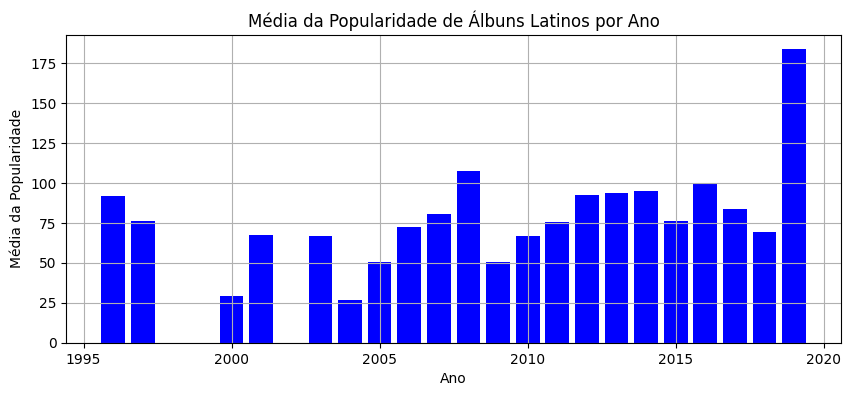

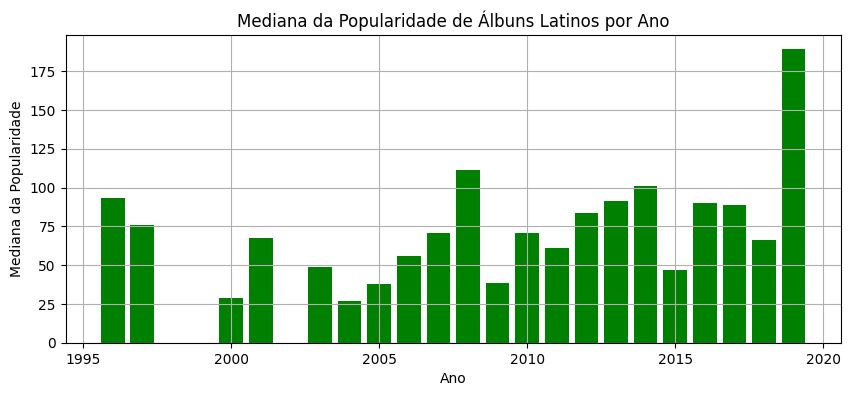

In [ ]:
top_albums_df['popularidade'] = 201 - top_albums_df['rank']

top_albums_df['ano'] = top_albums_df['date'].dt.year

yearly_popularity_mean = top_albums_df.groupby('ano')['popularidade'].mean()
yearly_popularity_median = top_albums_df.groupby('ano')['popularidade'].median()

plt.figure(figsize=(10, 4))
plt.bar(yearly_popularity_mean.index, yearly_popularity_mean, color='blue')
plt.title('Média da Popularidade de Álbuns Latinos por Ano')
plt.xlabel('Ano')
plt.ylabel('Média da Popularidade')
plt.grid(True)

plt.figure(figsize=(10, 4))
plt.bar(yearly_popularity_median.index, yearly_popularity_median, color='green')
plt.title('Mediana da Popularidade de Álbuns Latinos por Ano')
plt.xlabel('Ano')
plt.ylabel('Mediana da Popularidade')
plt.grid(True)

plt.show()

In [ ]:
num_permutacoes = 1000

proporcoes_observadas = []
p_valores = []

anos_inicio = list(range(1995, 2021, 5))
anos_fim = [ano for ano in anos_inicio[1:]]

latinos = df_albums[df_albums['artist'].isin(artistas)]
nao_latinos = df_albums[~df_albums['artist'].isin(artistas)]

for inicio, fim in zip(anos_inicio, anos_fim):
    dados_grupo_latino = latinos[(latinos['date'] >= str(inicio)) & (latinos['date'] <= str(fim))]
    dados_grupo_nao_latino = nao_latinos[(nao_latinos['date'] >= str(inicio)) & (nao_latinos['date'] <= str(fim))]

    media_latino = (201 - dados_grupo_latino['rank']).mean()
    media_nao_latino = (201 - dados_grupo_nao_latino['rank']).mean()

    proporcoes_permutadas = []
    for _ in range(num_permutacoes):
        permutacao_latino = np.random.permutation(dados_grupo_latino['rank'])
        permutacao_nao_latino = np.random.permutation(dados_grupo_nao_latino['rank'])
        permutacao_media_latino = (201 - permutacao_latino).mean()
        permutacao_media_nao_latino = (201 - permutacao_nao_latino).mean()
        proporcao_permutada = permutacao_media_latino / (permutacao_media_latino + permutacao_media_nao_latino)
        proporcoes_permutadas.append(proporcao_permutada)

    valor = media_latino / (media_nao_latino + media_latino)
    valor_nao_latino = media_nao_latino / (media_nao_latino + media_latino)
    p_valores.append((valor <= np.array(proporcoes_permutadas)).mean())
    proporcoes_observadas.append((inicio, fim, valor, valor_nao_latino))

for inicio, fim, valor, valor_nao_latino in proporcoes_observadas:
    print(f"Grupo de {inicio}-{fim}: Proporção Observada Latino = {valor:.4f}, Proporção Observada Não Latino = {valor_nao_latino:.4f}")

p_valor = sum(p_valores)/ len(p_valores)
print(p_valor)


Grupo de 1995-2000: Proporção Observada Latino = 0.5020, Proporção Observada Não Latino = 0.4980
Grupo de 2000-2005: Proporção Observada Latino = 0.5331, Proporção Observada Não Latino = 0.4669
Grupo de 2005-2010: Proporção Observada Latino = 0.4772, Proporção Observada Não Latino = 0.5228
Grupo de 2010-2015: Proporção Observada Latino = 0.4817, Proporção Observada Não Latino = 0.5183
Grupo de 2015-2020: Proporção Observada Latino = 0.4541, Proporção Observada Não Latino = 0.5459
1.0


Apesar de termos muito mais artistas não latinos, como estamos comparando as médias de popularidade de cada grupo, é normal que os valores das médias sejam parecidos.
Percebemos que a proporção da média de popularidade de artistas latinos diminuiu levemente ao longo dos anos, ao contrário do que estávamos esperando (já que nossa hipótese era de que a popularidade dos artistas latinos aumentou).

Ao printar o p_valor, percebemos que a proporção observada inicialmente de popularidade de latinos sobre o total é menor do que quando permutamos as popularidades.
Logo, devemos rejeitar a hipotese nula (de que as proporçoes entre a popularidade de latinos e nao latinos é equilibrada) e aceitar a alternativa (de que não há um equilíbrio).

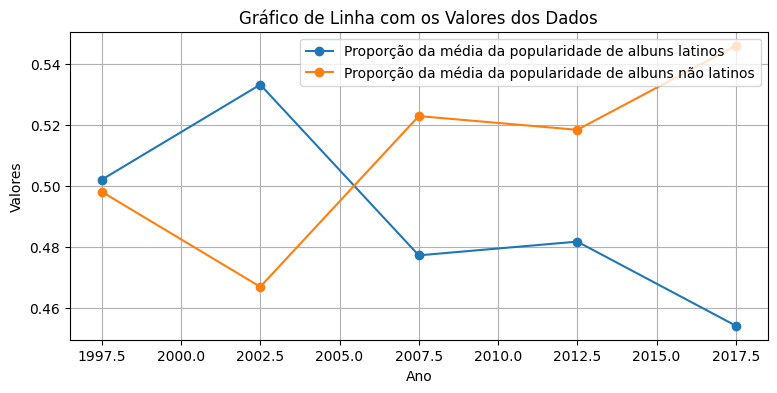

In [ ]:
anos_medios = [(inicio + fim) / 2 for inicio, fim, _, _ in proporcoes_observadas]
media_latina = [d[2] for d in proporcoes_observadas]
media_nao_latina = [d[3] for d in proporcoes_observadas]

plt.figure(figsize=(9, 4))
plt.plot(anos_medios, media_latina, label='Proporção da média da popularidade de albuns latinos', marker='o')
plt.plot(anos_medios, media_nao_latina, label='Proporção da média da popularidade de albuns não latinos', marker='o')

plt.xlabel('Ano')
plt.ylabel('Valores')
plt.title('Gráfico de Linha com os Valores dos Dados')
plt.legend()

plt.grid(True)
plt.show()

Para termos certeza das conclusões, foi feito um teste de hipótese, que concluiu que houve uma diminuição parcial na popularidade dos artistas de acordo com a base da Billboard, o que contrariou nossa hipótese inicial.

#Pergunta 2: Qual é a relação do sentimento da música com eventos externos (influência das épocas do ano ou eventos globais) no século XXI?

Unindo os dataframes para obter tanto as informações de rank quanto de features, e tratando a coluna data.

In [ ]:
df_aux = df_albums[['album', 'rank']]
df = df_features.merge(df_aux, left_on='album', right_on='album')
df['date'] = pd.to_datetime(df['date'])

Filtrando os dados para o século XXI.

In [ ]:
timeframe = df[df['date'].dt.year > 1999]
timeframe.dropna(inplace=True)

Criando uma categoria para as estações do ano baseadas na data.

In [ ]:
conditionlist = [
    (timeframe['date'].dt.month * 100 + timeframe['date'].dt.day >= 320) & (timeframe['date'].dt.month * 100 + timeframe['date'].dt.day <= 621), # primavera: 20 de março a 21 de junho
    (timeframe['date'].dt.month * 100 + timeframe['date'].dt.day >= 622) & (timeframe['date'].dt.month * 100 + timeframe['date'].dt.day <= 922), # verão: 22 de junho a 22 de setembro
    (timeframe['date'].dt.month * 100 + timeframe['date'].dt.day >= 923) & (timeframe['date'].dt.month * 100 + timeframe['date'].dt.day <= 1222), # outono: 23 de setembro a 22 de dezembro
    (timeframe['date'].dt.month * 100 + timeframe['date'].dt.day <= 319) | (timeframe['date'].dt.month * 100 + timeframe['date'].dt.day >= 1223) # inverno: 23 de dezembro a 19 de março
]

choicelist = ['primavera', 'verão', 'outono', 'inverno']
timeframe['season'] = np.select(conditionlist, choicelist)

Selecionando as features de interesse.

In [ ]:
selected_features = ['danceability', 'energy', 'tempo', 'valence', 'date', 'season']
timeframe = timeframe[selected_features]

Visualização da variação das features de interesse ao longo dos anos.

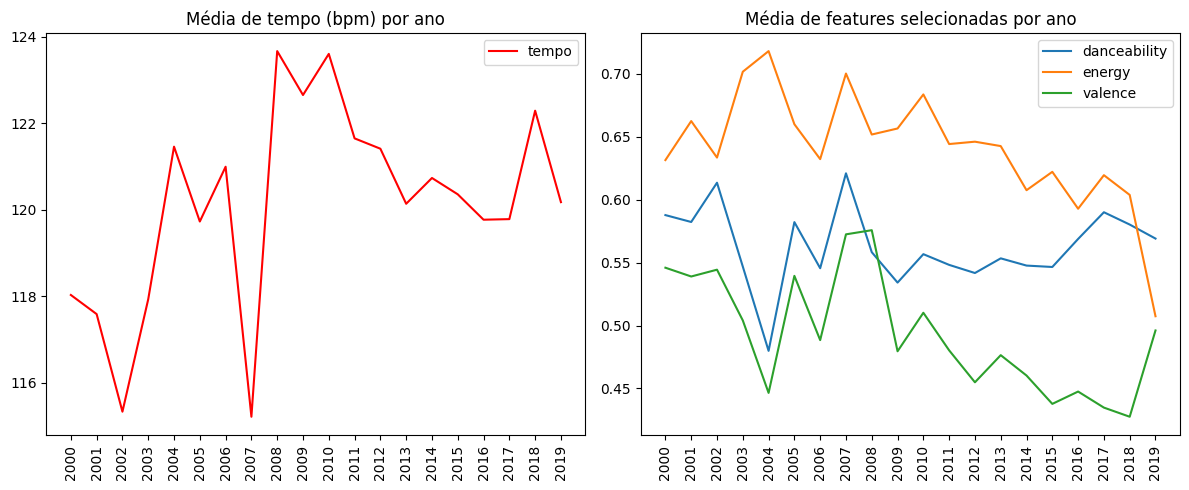

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# plot da feature 'tempo'
per_year_tempo = []
for i in range(2000, 2020):
    per_year_tempo.append(timeframe[timeframe['date'].dt.year == i]['tempo'].mean())

axes[0].plot(range(20), per_year_tempo, label='tempo', color='red')
axes[0].set_title('Média de tempo (bpm) por ano')
axes[0].set_xticks(range(20))
axes[0].set_xticklabels(range(2000, 2020), rotation=90)
axes[0].legend()

# plot das features 'danceability', 'energy' e 'valence'
selected_features = ['danceability', 'energy', 'valence']
for feature in selected_features:
    per_year = []
    for i in range(2000, 2020):
        per_year.append(timeframe[timeframe['date'].dt.year == i][feature].mean())
    axes[1].plot(range(20), per_year, label=feature)

axes[1].set_title('Média de features selecionadas por ano')
axes[1].set_xticks(range(20))
axes[1].set_xticklabels(range(2000, 2020), rotation=90)
axes[1].legend()

plt.tight_layout()
plt.show()

Visualização das médias das features de interesse ao longo das estações do ano.

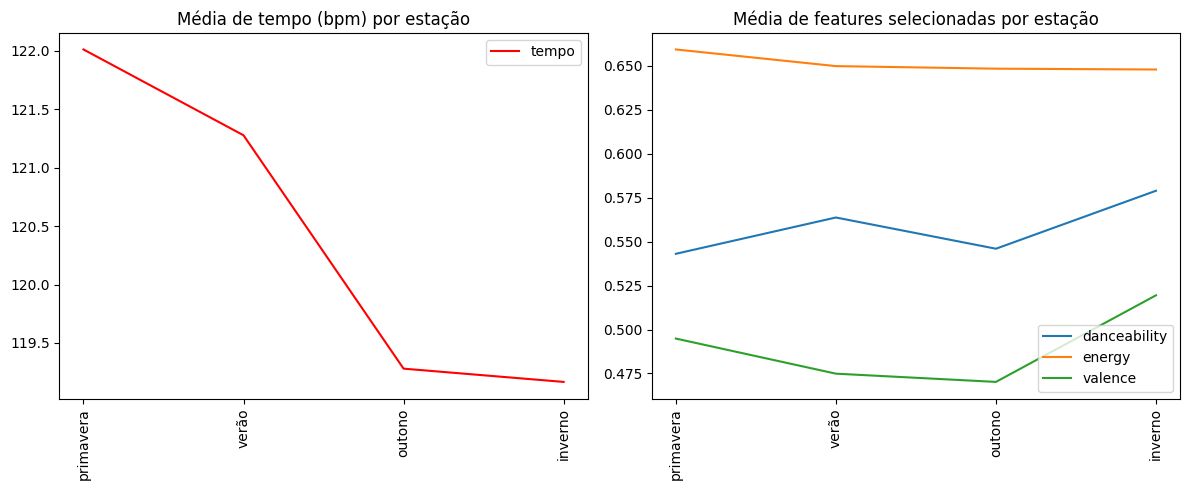

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# plot da feature 'tempo'
per_year_tempo = []
for i in choicelist:
    per_year_tempo.append(timeframe[timeframe['season'] == i]['tempo'].mean())

axes[0].plot(range(4), per_year_tempo, label='tempo', color='red')
axes[0].set_title('Média de tempo (bpm) por estação')
axes[0].set_xticks(range(4))
axes[0].set_xticklabels(choicelist, rotation=90)
axes[0].legend()

# plot das features 'danceability', 'energy' e 'valence'
selected_features = ['danceability', 'energy', 'valence']
for feature in selected_features:
    per_year = []
    for i in choicelist:
        per_year.append(timeframe[timeframe['season'] == i][feature].mean())
    axes[1].plot(range(4), per_year, label=feature)

axes[1].set_title('Média de features selecionadas por estação')
axes[1].set_xticks(range(4))
axes[1].set_xticklabels(choicelist, rotation=90)
axes[1].legend()

plt.tight_layout()
plt.show()

## Teste de hipótese
Hipótese nula: as estações do ano não influenciam atributos das músicas que fazem sucesso, ou seja, a diferença desses atributos é 0.

In [ ]:
features = ['danceability', 'energy', 'valence', 'tempo']
for feature in features:
  print('Feature: ' + feature)
  compare(feature, choicelist)
  print('\n')

Feature: danceability

Estação: primavera
Intervalo de confiança com 99%:  (-0.0005164333727655845, 0.0005816465259514567) | Valor observado:  -0.02298363753929944
P-valor:  1.0
Rejeita H0, ou seja, a diferença de mediana de danceability é significativa para a estação primavera


Estação: verão
Intervalo de confiança com 99%:  (-0.0005381054809092262, 0.0006621947792544695) | Valor observado:  0.003178022022296223
P-valor:  0.0
Rejeita H0, ou seja, a diferença de mediana de danceability é significativa para a estação verão


Estação: outono
Intervalo de confiança com 99%:  (-0.0004070036131310012, 0.0005494128566382304) | Valor observado:  -0.019749660165094274
P-valor:  1.0
Rejeita H0, ou seja, a diferença de mediana de danceability é significativa para a estação outono


Estação: inverno
Intervalo de confiança com 99%:  (-0.00045608554040450447, 0.0003980236538710897) | Valor observado:  0.0297167734143583
P-valor:  0.0
Rejeita H0, ou seja, a diferença de mediana de danceability é si

Como conclusão, observamos, por meio do valor-p, que a mudança de estação interfere nas features selecionadas, contrariando a hipótese nula.

#Pergunta 3: Qual a relação entre músicas que "hitaram" e a presença de videoclipes nelas?

Primeiro fizemos um tratamento no dataframe, selecionando as colunas de interesse, tirando musicas repetidas, removendo valores nulos e adicionando uma nova coluna que representa o total de views (spotify+youtube) de cada uma delas.

In [ ]:
# Selecionando colunas importantes
df = df_spotify_youtube.copy()
df = df[['Artist', 'Album','Track', 'Stream', 'Views', 'official_video']]
# Excluindo músicas repetidas
df.drop_duplicates(subset=['Track', 'Album'], inplace=True)
# Criando coluna com a quantidade de streams + views
df['Total_views'] = df['Views'] + df['Stream']
# Excluindo valores nulos
df['Total_views'] = df['Total_views'].dropna()
df['Views'] = df['Views'].dropna()

In [ ]:
# Excluindo músicas com menos de # milhões de views
df = df[df['Total_views'] > 100e6]

Como a escala dos valores totais de views esta na casa das centenas de milhoes, fiz uma transformação logaritmica e usei as medianas por esse mesmo motivo.

## Somando spotify + youtube

### Plotando os graficos

In [ ]:
sem_clipe = df[df['official_video'] == False].dropna().Total_views.values
com_clipe = df[df['official_video'] == True].dropna().Total_views.values
data = [sem_clipe, com_clipe]

Na questão de interesse, de inicio fizemos considerando a coluna criada que representa o total de views, e a visualizaçao desses dados foi feita utilizando dois tipos de gráficos, um box plot e um violin plot. Onde observamos que a media das musicas com clipe é relativamente maior.

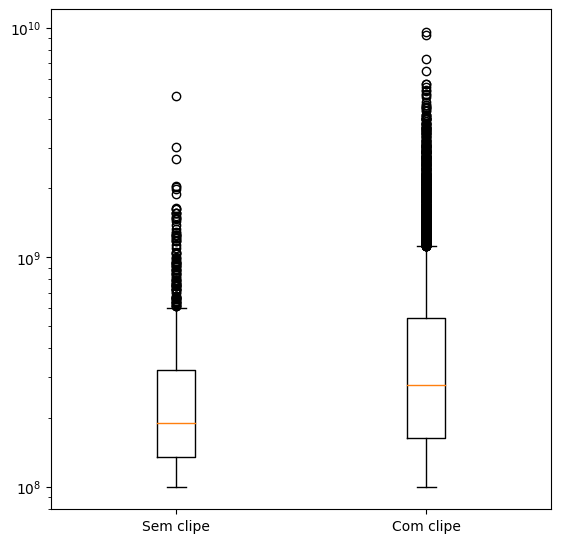

In [ ]:
fig = plt.figure(figsize =(5, 5))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
ax.set_yscale('log')
plt.xticks([1,2],['Sem clipe','Com clipe'])
plt.show()

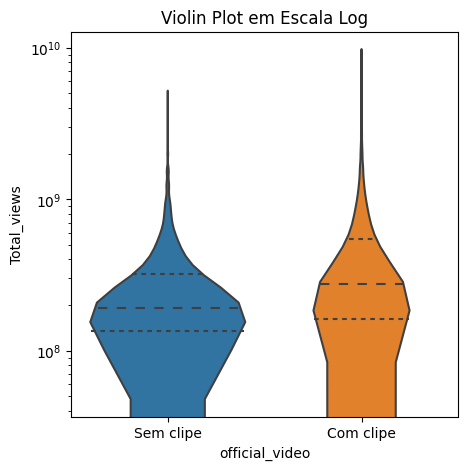

In [ ]:
# Dados de exemplo (substitua pelo seu conjunto de dados)
fig, ax = plt.subplots(figsize=(5, 5))

ax = sns.violinplot(data = df,x="official_video", y="Total_views",split=True, inner="quart")

# Ajuste a escala logarítmica no eixo y
ax.set_yscale('log')

# Defina rótulos para os violinos
ax.set_xticks([0, 1])
ax.set_xticklabels(['Sem clipe', 'Com clipe'])

# Adicione um título
ax.set_title('Violin Plot em Escala Log')

plt.show()


A partir dos resultados encontrados, formulamos a nossa hipotese nula de que músicas com clipe e sem clipe não possuem diferença no total de streams.

### Testando hipotese

In [ ]:
aux = df
filtro = aux['official_video'] == True
diffs, t_obs = shuffling(aux,'Total_views', filtro, 5000, False, log=True)

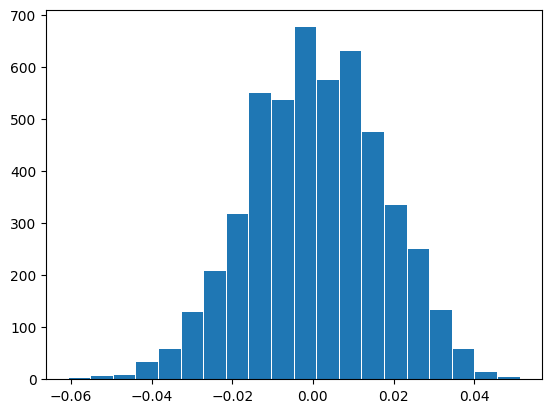

In [ ]:
plt.hist(diffs, bins=20, rwidth=0.95);

In [ ]:
print('Intervalo de confiança com 99%:', Intervalo_de_confianca(diffs))
print('Valor observado: ', t_obs)
print('p-valor:', p_value(t_obs, diffs))

Intervalo de confiança com 99%: (-0.04131727378340145, 0.03911999341962437)
Valor observado:  0.16204725508073103
p-valor: 0.0


Aṕos os testes de hipotese, percebemos que considerando o Spotify+Youtube a presença de video clipe está relacionada com número maior de streams total. Com esse resultado, resolvemos testar considerando apenas os números do Spotify.

## Apenas spotify

### Plotando os graficos

In [ ]:
sem_clipe = df[df['official_video'] == False].dropna().Stream.values
com_clipe = df[df['official_video'] == True].dropna().Stream.values
data = [sem_clipe, com_clipe]

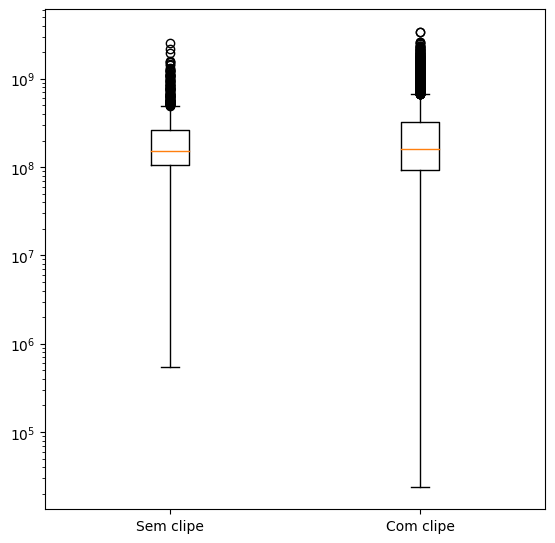

In [ ]:
fig = plt.figure(figsize =(5, 5))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
ax.set_yscale('log')
plt.xticks([1,2],['Sem clipe','Com clipe'])
plt.show()

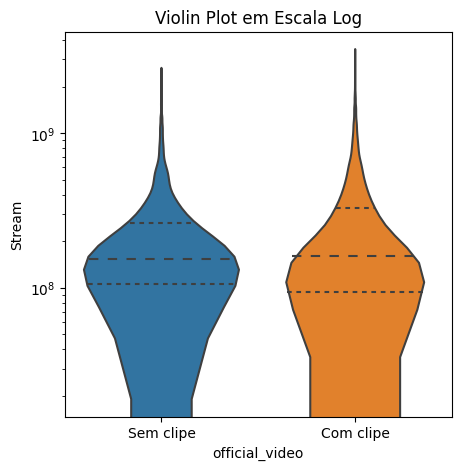

In [ ]:
# Dados de exemplo (substitua pelo seu conjunto de dados)
fig, ax = plt.subplots(figsize=(5, 5))

ax = sns.violinplot(data = df,x="official_video", y="Stream",split=True, inner="quart")

# Ajuste a escala logarítmica no eixo y
ax.set_yscale('log')

# Defina rótulos para os violinos
ax.set_xticks([0, 1])
ax.set_xticklabels(['Sem clipe', 'Com clipe'])

# Adicione um título
ax.set_title('Violin Plot em Escala Log')

plt.show()


### Testando hipotese

H0 = Músicas com clipe e sem clipe possuem o mesmo tanto de visualizações + streams

In [ ]:
aux = df
filtro = aux['official_video'] == True
diffs, t_obs = shuffling(aux,'Stream', filtro, 5000, False, log=True)

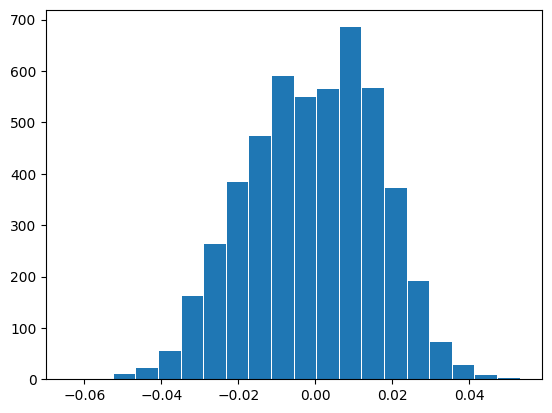

In [ ]:
plt.hist(diffs, bins=20, rwidth=0.95);

In [ ]:
print('Intervalo de confiança com 99%:', Intervalo_de_confianca(diffs))
print('Valor observado: ', t_obs)
print('p-valor:', p_value(t_obs, diffs))

Intervalo de confiança com 99%: (-0.04175611965762398, 0.0378327409216839)
Valor observado:  0.018805696181805942
p-valor: 0.1202


## Conclusões


In [ ]:
print('Threshold \t Spotify+Youtube \t Spotify')
print('100e6 \t\t 0.0000 \t\t 0.1202')
print('200e6 \t\t 0.0000 \t\t 0.8974')
print('300e6 \t\t 0.0000 \t\t 0.9562')
print('400e6 \t\t 0.0000 \t\t 0.9984')
print('500e6 \t\t 0.0000 \t\t 0.9974')
print('1000e6 \t\t 0.0506 \t\t 0.9904')
print('1500e6 \t\t 0.0252 \t\t 0.6312')

Threshold 	 Spotify+Youtube 	 Spotify
100e6 		 0.0000 		 0.1202
200e6 		 0.0000 		 0.8974
300e6 		 0.0000 		 0.9562
400e6 		 0.0000 		 0.9984
500e6 		 0.0000 		 0.9974
1000e6 		 0.0506 		 0.9904
1500e6 		 0.0252 		 0.6312


Após repetir todos os procedimentos, obtivemos resultados mais interessantes, onde dependendo do quanto a música "hitou" a presença de videocilpe tinha influência ou não, concluimos que em geral, a quantidade de streams esta ligada com esse fator, mas existem alguns casos que a ausencia de video clipe não influenciou negativamente no sucesso da música, esses casos são para músicas extremamente famosas, definimos como 1.5B de visualizações somadas e quando a música é um "hit local" quando esta entre 100 e 200 milhões

#Pergunta 4: Nos últimos anos, dentre as músicas com mais streams, quais os valores médios de aspectos técnicos que fazem mais sucesso?

Importando o dataframe dos charts do Spotify em 2022, agrupando os ranks e tirando a média deles, e fazendo um tratamento para converter a duração das músicas de milissegundos para minutos. O agrupamento foi feito para facilitar a visualização de como a duração média das músicas para cada rank varia.

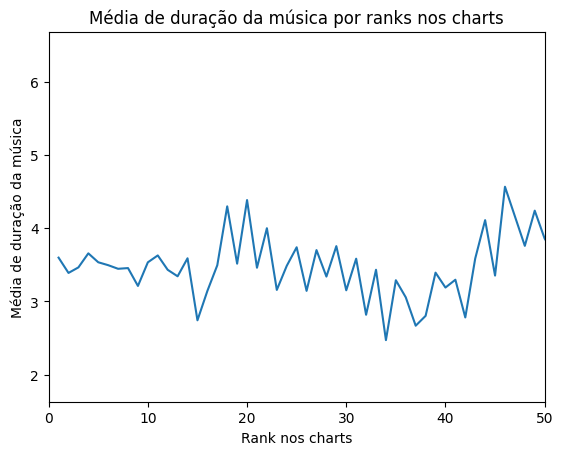

In [ ]:
df = df_spotify_2022.copy().dropna()
sorted = df.groupby('peak_rank').mean()
sorted['duration_min'] = divmod((sorted['duration_ms'] / 60000), 60)[1]

plt.plot(sorted['duration_min'])
plt.xlim([0, 50])
plt.title('Média de duração da música por ranks nos charts')
plt.xlabel('Rank nos charts')
plt.ylabel('Média de duração da música')
plt.show()

Hipótese nula: o tempo de duração entre as músicas de sucesso não é curto, ou seja, as músicas não estão ficando curtas com o tempo

In [ ]:
song_minutes = df.copy()
song_minutes['duration_min'] = divmod((song_minutes['duration_ms'] / 60000), 60)[1]
filtro = song_minutes['duration_min'] > 4.0

alpha = 0.95
N = 5000
diffs, t_obs = shuffling(song_minutes, 'peak_rank', filtro, N)
print(f'Intervalo de confiança com {alpha*100}%: {Intervalo_de_confianca(diffs)}')
print(f'Valor observado: {t_obs}')
print(f'P-valor: {p_value(t_obs, diffs)}')

Intervalo de confiança com 95.0%: (-14.81596805092077, 15.156393987146224)
Valor observado: -5.7027252502780925
P-valor: 0.8368


Como o p-valor é significativamente bom para o valor observado (músicas com mais de 4 minutos de duração), podemos concluir que as músicas de sucesso não estão sendo encurtadas, o que comprova a hipótese nula.

Em seguida, foi avaliada a felicidade das músicas, representada pelo valor numérico valence. O grupo postulou que as músicas de sucesso estão mais tristes. Nesse caso, a hipótese nula é que as músicas não estão tristes.

In [ ]:
songs_valence = df_spotify_youtube.copy()
filtro = songs_valence['Valence'] > 0.5

alpha = 0.95

N = 5000
diffs, t_obs = shuffling(songs_valence, 'Stream', filtro, N)
print(f'Intervalo de confiança com {alpha*100}%: {Intervalo_de_confianca(diffs)}')
print(f'Valor observado: {t_obs}')
print(f'P-valor: {p_value(t_obs, diffs)}')

Intervalo de confiança com 95.0%: (-9454332.83227515, 9051004.047054803)
Valor observado: -8335122.602329403
P-valor: 0.9902


Como o p-valor é significativamente ruim para o valor observado (músicas com mais de 0.5 de valência), podemos concluir que as músicas de sucesso estão de fato mais tristes, o que contraria a hipótese nula.

# Regressão e Classificação

Para a regressão, utilizamos as bases de dados que possuiam informações relacionadas ao sucesso das músicas (como número de streams, likes, views, etc) e detalhes técnicos da música. Isso era melhor representado pela base que relacionava dados do spotify com dados do youtube.

In [ ]:
df = df_spotify_youtube.copy().dropna()
df = df.drop(['Unnamed: 0', 'Key'], axis=1)
df = pd.get_dummies(df, columns=['official_video'], drop_first=True)

Visualização da correlação entre as variáveis da primeira base de dados por meio de um heatmap.

<Axes: >

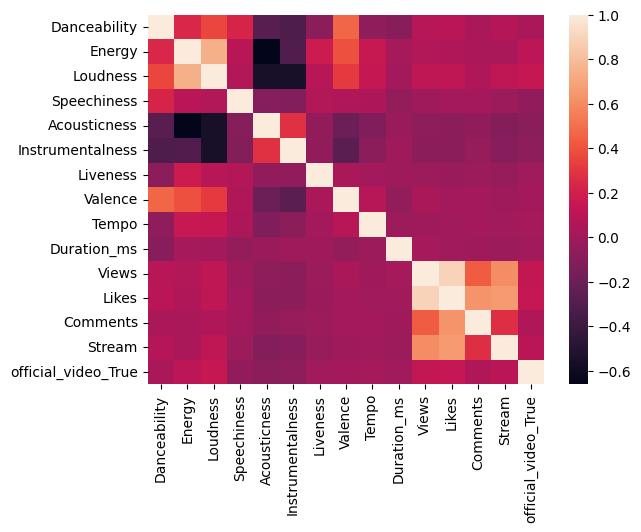

In [ ]:
sns.heatmap(df.corr())

Visualização da correlação entre as variáveis da segunda base de dados por meio de um heatmap.

Z normalizando os dados de entrada e utilizando o Ordinary Least Squares para fazer uma regressão múltipla entre os dados mais correlacionados na primeira base.

In [ ]:
z_df_spotify_youtube = (df - df.mean())/df.std(ddof=1)

y = z_df_spotify_youtube['Stream']
X = z_df_spotify_youtube[['Views','Likes','Comments']]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 Stream   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     5622.
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        10:37:43   Log-Likelihood:                -21150.
No. Observations:               19170   AIC:                         4.231e+04
Df Residuals:                   19166   BIC:                         4.234e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.228e-17      0.005  -9.92e-15      1.0

Apesar de termos atributos que não possuem uma amplitude alta no IC e não passam pelo 0, a regressão não é muito boa, o que pode ser visualizado pelo seu R².

<Axes: xlabel='Comments', ylabel='Stream'>

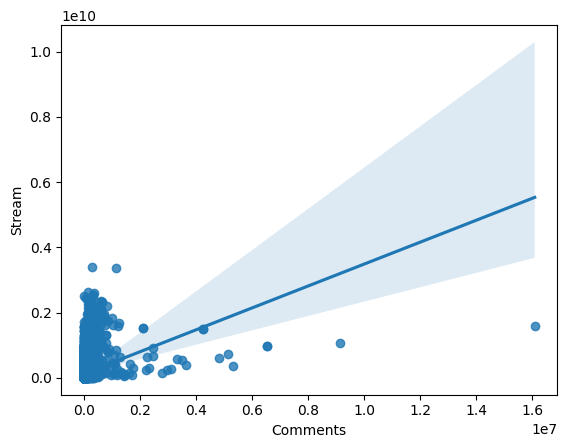

In [ ]:
sns.regplot(data=df, x='Comments', y='Stream')

Utilizando o OLS novamente, agora com os atributos referentes à detalhes técnicos das músicas.

In [ ]:
y = z_df_spotify_youtube['Stream']
X = z_df_spotify_youtube[['Danceability', 'Energy', 'Loudness', 'Speechiness','Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo','Duration_ms']]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 Stream   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     59.83
Date:                Wed, 29 Nov 2023   Prob (F-statistic):          3.47e-120
Time:                        01:03:30   Log-Likelihood:                -26906.
No. Observations:               19170   AIC:                         5.383e+04
Df Residuals:                   19159   BIC:                         5.392e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -5.228e-17      0.007  

<Axes: xlabel='Danceability', ylabel='Stream'>

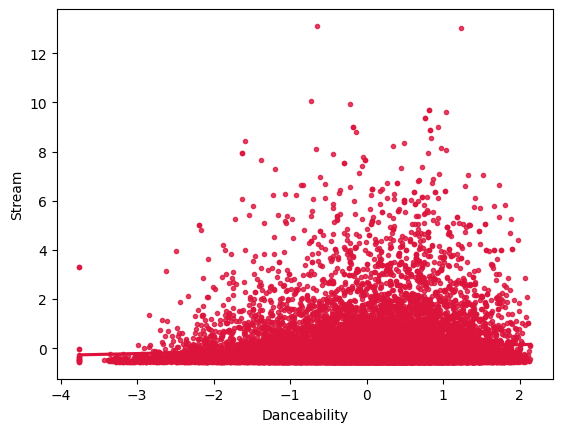

In [ ]:
sns.regplot(data=z_df_spotify_youtube, color='crimson', marker='.', x='Danceability', y='Stream')

Podemos perceber que o R² não é muito bom, logo uma regressão não seria possível de sumarizar os detalhes técnicos presentes nas músicas de sucesso.

Com isto em mente, o grupo resolveu utilizar uma técnica de clusterização chamada Kmeans, de maneira a conseguir categorizar elementos técnicos presentes nas diferentes músicas, e com isso criar uma relação entre sucesso e estes aspectos.

In [ ]:
new_df = df.copy()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(new_df[['Stream','Views','Likes']])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)

Para descobrir o ponto ótimo de divisão de clusters, foi utilizado o método Elbow. O gráfico Elbow mostra a soma dos erros quadrados dentro do cluster (WCSS) no eixo y e o número de clusters no eixo x. O valor ótimo deste último é o ponto de cotovelo no gráfico.

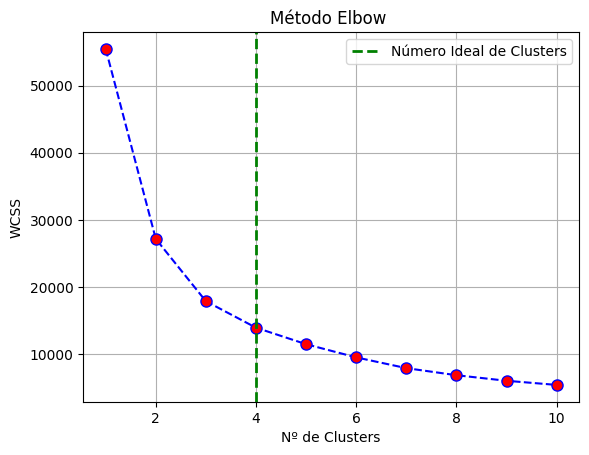

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(principal_components)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='b', markerfacecolor='r', markersize=8)
plt.title('Método Elbow ')
plt.xlabel('Nº de Clusters')
plt.ylabel('WCSS')
plt.grid(True)

plt.axvline(x=4, color='g', linestyle='--', linewidth=2, label='Número Ideal de Clusters')
plt.legend()
plt.show()

Apesar do método acima recomendar 4 clusters, fizemos um teste com 3 e 5 para analisar a distribuição nestes, e optamos por utilizar 5.

In [ ]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
new_df['popularity_cluster'] = kmeans.fit_predict(principal_components)

print(new_df['Stream'].groupby(new_df['popularity_cluster']).mean()/1e6)

name_mapper = {2: 'Super Popular', 1: 'Muito Popular', 3: 'Popular', 4: 'Popular', 0:'Pouco Popular'}
new_df['popularity_group'] = new_df['popularity_cluster'].map(name_mapper)

popularity_cluster
0      57.215104
1    1302.228705
2    1634.645958
3     857.815234
4     346.450683
Name: Stream, dtype: float64


In [ ]:
pio.templates.default = "plotly_dark"
cores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

num_cols = new_df.select_dtypes(include=['int64', 'float64', 'uint8']).columns
num_cols = num_cols.drop(['Stream', 'Comments', 'Likes', 'Views'])

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(new_df[num_cols]), columns=num_cols)

df_scaled['popularity_group'] = new_df['popularity_group']
traces = []
for i, cat in enumerate(df_scaled['popularity_group'].unique()):
    data = df_scaled[df_scaled['popularity_group'] == cat][num_cols].mean().tolist()
    trace = go.Scatterpolar(
        r=data + data[:1],
        theta=[col for col in num_cols.tolist()] + [num_cols[0]],
        fill='toself',
        name=cat,
        line=dict(color=cores[i]),
        fillcolor=cores[i],
        opacity=0.8
    )
    traces.append(trace)

layout = go.Layout(
    polar = dict(radialaxis=dict(visible=True)),
    showlegend=True,
    title = 'Atributos x Popularidade',
)

fig = go.Figure(data=traces, layout=layout)
fig.show()

Podemos concluir então que as músicas mais populares são mais dançáveis, possuem um BPM maior e possuem mais vozes do que as demais. Logo, uma música de sucesso deve maximizar estes parâmetros. Para validar as descobertas, foi calculado o intervalo de confiança e o índice de silhueta, uma métrica de validação do Kmeans.

In [ ]:
def run_kmeans(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    return silhouette

def bootstrap_kmeans(X, n_clusters, n_iterations):
    silhouette_scores = []

    for _ in range(n_iterations):
        bootstrap_sample = X[np.random.choice(len(X), len(X), replace=True)]
        silhouette = run_kmeans(bootstrap_sample, n_clusters)
        silhouette_scores.append(silhouette)

    mean_score = np.mean(silhouette_scores)
    std_dev = np.std(silhouette_scores)
    confidence_interval = (mean_score - 1.96 * std_dev, mean_score + 1.96 * std_dev)

    return mean_score, confidence_interval

n_clusters = 5
n_iterations = 100
mean_score, confidence_interval = bootstrap_kmeans(principal_components, n_clusters, n_iterations)

print(f"Índice de silhueta médio: {mean_score}")
print(f"Intervalo de confiança: {confidence_interval}")

Índice de silhueta médio: 0.6822794911851586
Intervalo de confiança: (0.6501404785274116, 0.7144185038429056)


In [ ]:
silhouette = run_kmeans(principal_components, 5)
print(f"Índice de silhueta observado: {silhouette}")

Índice de silhueta observado: 0.6748602280215562


Como o valor observado está dentro do intervalo de confiança, a estimativa é boa.